In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from brainspace.utils.parcellation import map_to_labels
from matplotlib.colors import ListedColormap
import func_plot as fp
import func_stats as fs
from brainspace.datasets import load_conte69
lh, rh = load_conte69()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
data_raw = loadmat('../nspn/NSPN_Baseline_Data.mat')
mp2 = data_raw['MP2_bl'].mean(axis=0)
mp2.shape, data_raw.keys()

((360, 286),
 dict_keys(['__header__', '__version__', '__globals__', 'MP2_bl', 'MTmoments', 'age_bl', 'icv_bl', 'sex_bl', 'site_bl', 'subj_bl']))

In [3]:
data_raw['sex_bl'][data_raw['sex_bl']=='female'] = 'F'
data_raw['sex_bl'][data_raw['sex_bl']=='male'] = 'M'
data_raw['sex_bl'].shape, data_raw['age_bl'].shape

((286, 1), (286, 1))

In [4]:
data_raw['sex_bl']

array([['F'],
       ['M'],
       ['F'],
       ['F'],
       ['M'],
       ['M'],
       ['F'],
       ['F'],
       ['F'],
       ['M'],
       ['M'],
       ['F'],
       ['F'],
       ['M'],
       ['F'],
       ['M'],
       ['M'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['F'],
       ['F'],
       ['M'],
       ['F'],
       ['M'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['M'],
       ['M'],
       ['F'],
       ['M'],
       ['F'],
       ['M'],
       ['M'],
       ['M'],
       ['F'],
       ['M'],
       ['M'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
       ['M'],
       ['M'],
       ['M'],
       ['F'],
       ['M'],
       ['F'],
       ['M'],
       ['F'],
       ['F'],
       ['M'],
       ['F'],
       ['F'],
       ['F'],
       ['F'],
      

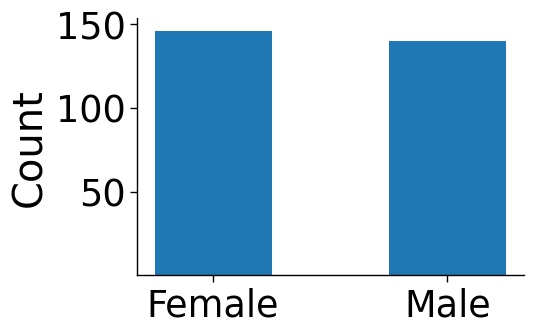

In [5]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(data_raw['sex_bl'].T[0],bins=[0,0.5,1,1.5])
ax.set_xticks([0.25,1.25])
ax.set_yticks([50,100,150])
ax.set_ylabel('Count')
ax.set_xticklabels(['Female','Male'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../figures/nspn/sex_distribution.png', dpi=300, transparent=True)

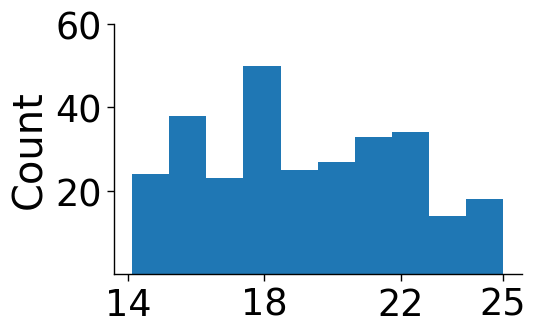

In [6]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(data_raw['age_bl'])
ax.set_xticks([14,18, 22, 25])
ax.set_yticks([20, 40, 60])
ax.set_ylabel('Count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../figures/nspn/age_distribution.png', dpi=300, transparent=True)

In [7]:
lh_inten = mp2[:180]
rh_inten = mp2[180:]

lh_z = np.array([ss.zscore(lh_inten[:,n], axis = None) for n in range(286)])
rh_z = np.array([ss.zscore(rh_inten[:,n], axis = None) for n in range(286)])

mp = np.concatenate((lh_z, rh_z),axis=1)
mp.shape

(286, 360)

In [8]:
asy_total = lh_z - rh_z
asy_total.shape

(286, 180)

In [9]:
a = []
for i in range(180):
  a.append(ss.ttest_1samp(asy_total[:,i],0))
cohen = np.array(a)[:,0]/pow(286, 0.5)
df_total = pd.DataFrame(np.vstack((np.array(a).T, fs.fdr(np.array(a)[:,1]), cohen)).T)
df_total.columns = ['t', 'p', 'p_fdr','cohen']
df_total.to_csv('../nspn/stat_nspn_intensity_asy_total_parcel.csv', index=None)
df_total

,t,p,p_fdr,cohen
0,-15.888536,3.795380e-41,2.277228e-39,-0.939509
1,-1.377065,1.695727e-01,2.164758e-01,-0.081428
2,-5.553049,6.432264e-08,2.067513e-07,-0.328359
3,-14.015836,2.625939e-34,1.181673e-32,-0.828774
4,-9.354646,2.583556e-18,2.906500e-17,-0.553152
...,...,...,...,...
175,10.099039,1.065760e-20,1.918368e-19,0.597169
176,-0.497522,6.192048e-01,6.837844e-01,-0.029419
177,4.440090,1.287326e-05,3.131333e-05,0.262548
178,6.239942,1.579517e-09,6.318067e-09,0.368975


In [10]:
glasser = np.genfromtxt('../data/glasser.csv')
glasser_l = glasser[:32492]
glasser_r = glasser[32492:]
glasser_r[glasser_r==180]=0
glasser = np.concatenate((glasser_l,glasser_r))
mask = glasser != 0

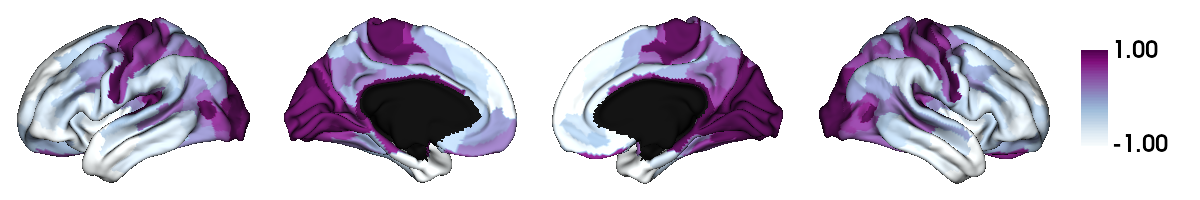

In [11]:
mask = glasser != 0
plot = map_to_labels(mp.mean(axis=0), glasser, mask=mask)
np.savetxt('../nspn/NSPN_intensity_z_mean.txt', mp.mean(axis=0))
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'BuPu', filename = '../figures/nspn/mean.png')

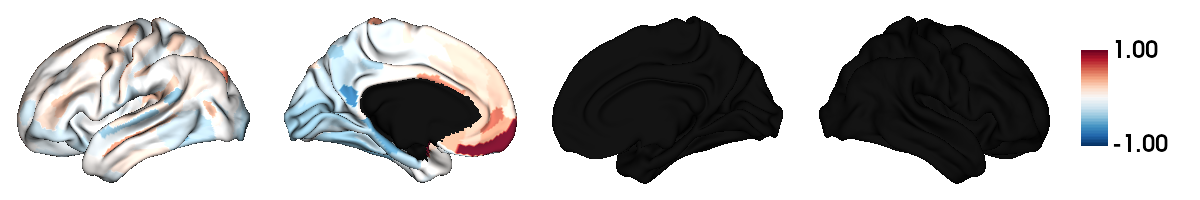

In [13]:
plot = asy_total.mean(axis=0)
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
np.savetxt('../nspn/NSPN_intensity_asy_mean.txt', asy_total.mean(axis=0))
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'RdBu_r', filename = '../figures/nspn/mean_asy.png')

In [14]:
import hcp_utils as hcp
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv', header = None))[:,0]
cmap = ListedColormap(np.vstack((list(hcp.ca_network['rgba'].values())))[1:])
color = ca[:180]

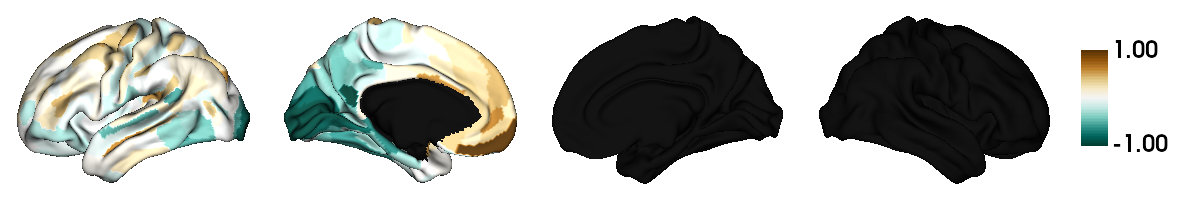

In [15]:
plot=cohen.copy()
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'BrBG_r', filename = '../figures/nspn/mean_asy_cohen.png')

[PearsonRResult(statistic=0.33777218758124833, pvalue=3.532679172400295e-06),
 '=0.036']

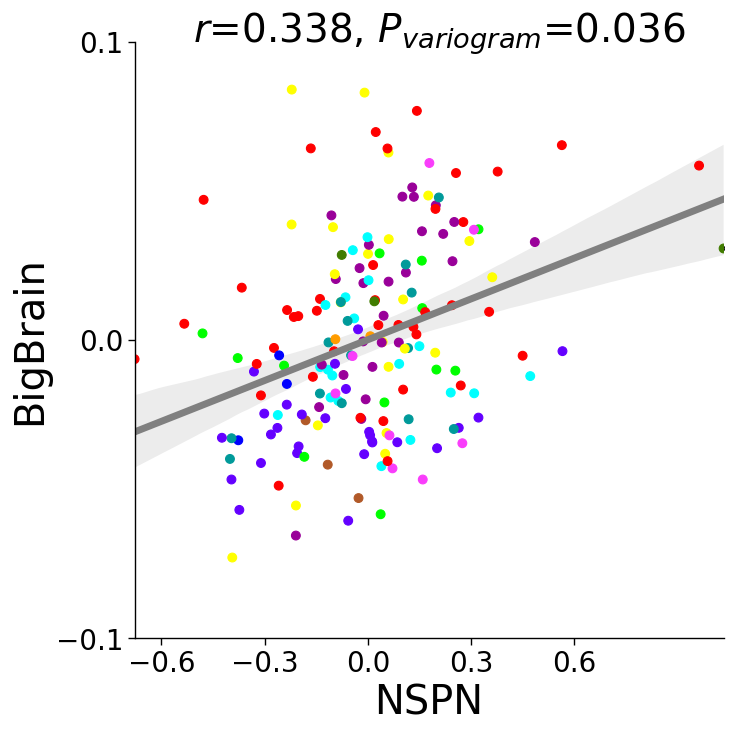

In [17]:
data = asy_total.mean(axis=0).copy()
bb_asy = np.loadtxt('../bigbrain/bigbrain_asy_mean.txt')
target = bb_asy.copy()
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([-0.1, 0, 0.1])
ax.set_xticks([-0.6, -0.3, 0, 0.3, 0.6])
ax.set_xlabel('NSPN')
ax.set_ylabel('BigBrain')
if rp[1] == 0:
   rp[1] = '<0.001'
else:
   rp[1] = '=%.3f'%(rp[1])
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$'+rp[1], 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/nspn/corr_nspn_bb_asy_mean.png', dpi=300, transparent=True)
rp

[PearsonRResult(statistic=0.3692224233400801, pvalue=3.3873729926615413e-07),
 '=0.047']

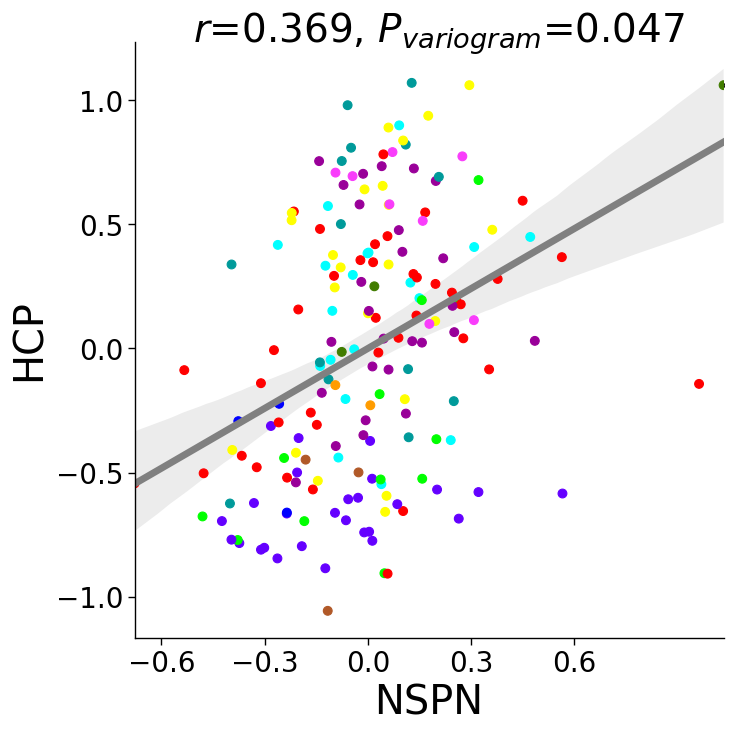

In [18]:
data = asy_total.mean(axis=0)
hcp_asy = np.loadtxt('../hcp/intensity_asy_mean.txt')
target = hcp_asy.copy()
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticks([-0.6, -0.3, 0, 0.3, 0.6])
ax.set_xlabel('NSPN')
ax.set_ylabel('HCP')
if rp[1] == 0:
   rp[1] = '<0.001'
else:
   rp[1] = '=%.3f'%(rp[1])
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$'+rp[1], 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/nspn/corr_nspn_hcp_asy_mean.png', dpi=300, transparent=True)
rp

## Sex Age effects

In [19]:
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
sex = FixedEffect(data_raw['sex_bl'][:,0], 'sex')
age = FixedEffect(data_raw['age_bl'][:,0], 'age')
sum(sex.sex_F)/286, age.age.min(), age.age.max(), age.age.mean(), age.age.std()

(0.5104895104895105, 14.12, 25.01, 19.13828671328671, 2.87416163543505)

In [22]:
model = sex + age + sex*age
slm_age_sex = SLM(model, contrast=model.matrix['sex_M*age'])
slm_age_sex.fit(asy_total)
t_age_sex = slm_age_sex.t[0]
p_age_sex = np.zeros(180)
dof = model.shape[0] - model.shape[1]
for i in range(180):
  p_age_sex[i] = ss.t.sf(abs(t_age_sex[i]), dof) * 2
if len(np.where(fs.fdr(p_age_sex)<0.05)[0]) == 0:
  print('no age*sex interaction')
  model = sex + age
  slm_sex = SLM(model, contrast=model.sex_M)
  slm_sex.fit(asy_total)
  slm_age = SLM(model, contrast=model.age)
  slm_age.fit(asy_total)
  t_sex = slm_sex.t[0]
  t_age = slm_age.t[0]
  p_sex = np.zeros(180)
  p_age = np.zeros(180)
  dof = model.shape[0] - model.shape[1]
  for i in range(180):
    p_sex[i] = ss.t.sf(abs(t_sex[i]), dof) * 2
    p_age[i] = ss.t.sf(abs(t_age[i]), dof) * 2
else:
  np.where(fs.fdr(p_age_sex)<0.05)[0]

np.savetxt('../nspn/NSPN_sex_t.txt', t_sex)
np.savetxt('../nspn/NSPN_sex_p.txt', p_sex)
np.savetxt('../nspn/NSPN_sex_pfdr.txt', fs.fdr(p_sex))
np.savetxt('../nspn/NSPN_age_t.txt', t_age)
np.savetxt('../nspn/NSPN_age_p.txt', p_age)
np.savetxt('../nspn/NSPN_age_pfdr.txt', fs.fdr(p_age))

no age*sex interaction


In [23]:
[t_sex.min(), t_sex.max(), t_age.min(), t_age.max(),
 p_sex.min(), p_sex.max(), p_age.min(), p_age.max(),] 

[-3.645650458241069,
 2.664175101821534,
 -2.5411825177304452,
 3.5004000780797515,
 0.0003175116526866665,
 0.9968893380453696,
 0.0005397967318954821,
 0.9996398524086223]

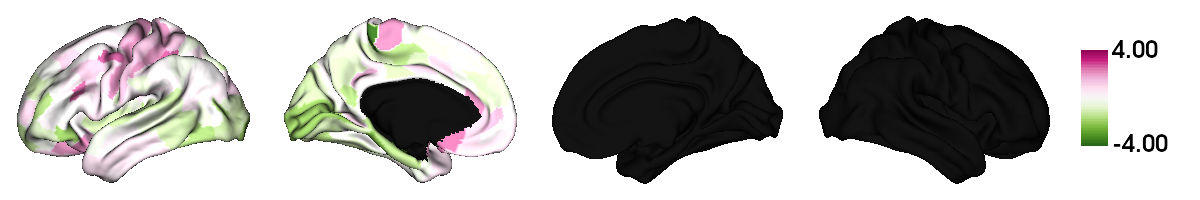

In [24]:
plot = t_sex.copy()
#plot[fs.fdr(p_sex)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-4,4),
                   cmap = 'PiYG_r', filename = '../figures/nspn/asy_tmap_sex.png')

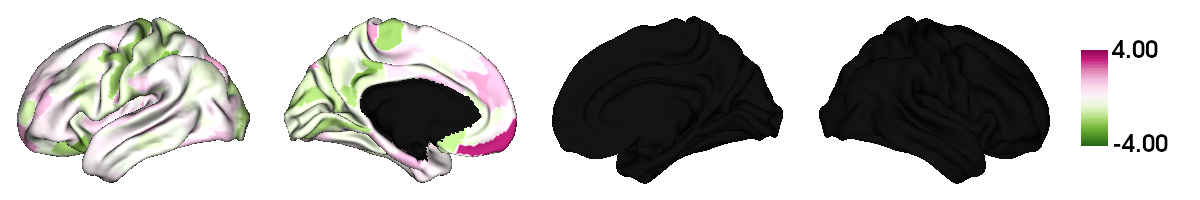

In [25]:
plot = t_age.copy()
#plot[fs.fdr(p_age)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-4,4),
                   cmap = 'PiYG_r', filename = '../figures/nspn/asy_tmap_age.png')

([PearsonRResult(statistic=0.3579802162296376, pvalue=8.062663490965814e-07),
  '<0.001'],
 [PearsonRResult(statistic=0.32287309668014763, pvalue=9.84291728849084e-06),
  '<0.001'])

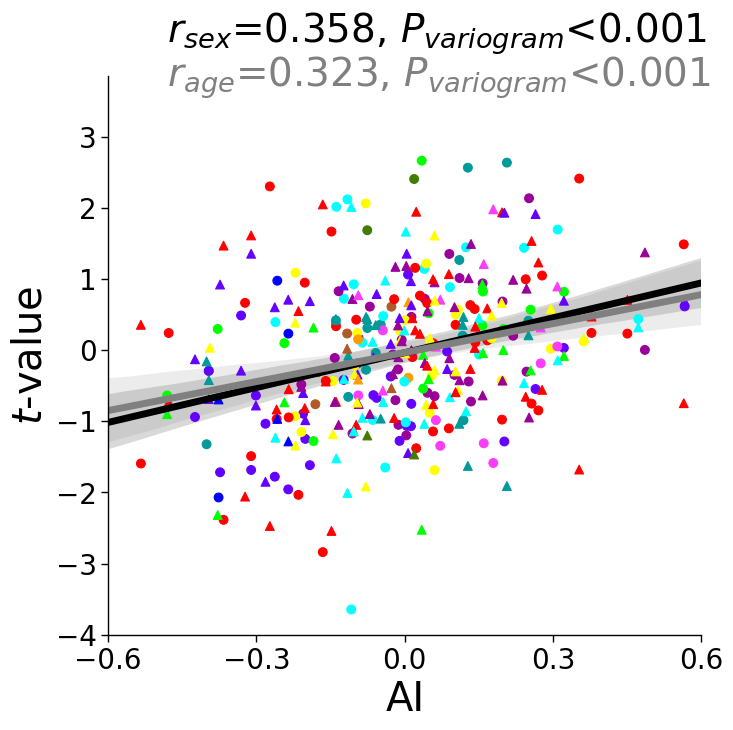

In [26]:
target1=t_sex.copy()
target2=t_age.copy()
data = asy_total.mean(axis=0)
rp1 = fs.spin_pearson(data, target1)
rp2 = fs.spin_pearson(data, target2)
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target1, ax = ax, 
            scatter_kws={'s': 0, 'color': 'red'},
            line_kws={'lw': 5, 'color': 'black'})
sns.regplot(data, target2, ax = ax, 
            scatter_kws={'s': 0, 'color': 'blue'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target1, c=ca[:180], cmap=cmap, s=40)
ax.scatter(data, target2, c=ca[:180], cmap=cmap, s=40, marker='^')
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-0.6, 0.6)
#ax.set_ylim(-0.1, 0.1)
#ax.set_yticks([-0.1, 0, 0.1])
ax.set_xticks([-0.6, -0.3, 0, 0.3, 0.6])
ax.set_xlabel('AI')
ax.set_ylabel('$\it{t}$-value')
if rp1[1] == 0:
   rp1[1] = '<0.001'
else:
   rp1[1] = '=%.3f'%(rp1[1])
if rp2[1] == 0:
   rp2[1] = '<0.001'
else:
   rp2[1] = '=%.3f'%(rp2[1])
   
ax.text(0.1, 1.06, '$\it{r}$$_{sex}$=' + '%.3f'%(rp1[0][0])+', $\it{P}$$_{variogram}$'+rp1[1], 
        fontsize=28, c='black', transform=ax.transAxes)
ax.text(0.1, 0.98, '$\it{r}$$_{age}$=' + '%.3f'%(rp2[0][0])+', $\it{P}$$_{variogram}$'+rp2[1], 
        fontsize=28, c='grey', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/nspn/corr_tmap_sex_age.png', dpi=300, transparent=True)
rp1, rp2